In [27]:
import random
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import seaborn as sns
import statsmodels
from statsmodels.othermod.betareg import BetaModel
from statsmodels.genmod.families.links import cloglog,log,logit,probit,nbinom
import statsmodels.formula.api as smf

# Estimating number of mafia needed

Below is edited code from https://www.alexirpan.com/2015/08/25/perfectly-intelligent-mafia.html to find the number of mafia needed in a given mafia game of n players so that the probability of winning of both parties is 50-50.


In [33]:
# import random

# def simulate_game(n, m):
#     # Simulate a game with n players, m mafia
#     while n > 2 * m:
#         # Lynch random player
#         if random.randint(0, n - 1) < m:
#             m -= 1
#         if m == 0:
#             return False  # Town wins
#         # Mafia kills one townsperson
#         n -= 2
#     return True  # Mafia wins

# def get_win_odds(n, m, trials=10000):
#     return sum(simulate_game(n, m) for _ in range(trials)) / trials

# def find_5050(n):
#     threshold = 0.02
#     low = 1 #minimum number of mafia
#     high = n #maximum number of mafia
#     while low < high: #binary search
#         mid = (low + high) // 2
#         per = get_win_odds(n, mid)
#         #print(f'N={n}, low={low}, high={high}, mid={mid}, win chance={per:.3f}')
#         if abs(per - 0.5) < threshold: #if per is around 0.48-0.52% => will be considered 50 50
#             return mid
#         elif per < 0.5:
#             low = mid + 1
#         else:
#             high = mid
#     return low

# list_of_mafia = []
# # Run for N = 7 to 15
# for N in range(7, 100):
#     #print(f'\nGroup size N = {N}')
#     mafia_needed = find_5050(N)
#     list_of_mafia.append((N, mafia_needed))



In [34]:
# import matplotlib.pyplot as plt

# # Unzip the list into two separate lists
# n_vals, mafia_vals = zip(*list_of_mafia)

# # Plot
# plt.figure(figsize=(8, 6))
# plt.plot(n_vals, mafia_vals, marker='o', linestyle='-')
# plt.ylabel('Number of Mafia Needed for ~50% Win Rate')
# plt.xlabel('Total Number of Players')
# plt.title('Minimum Mafia Needed vs Group Size (Uniform Random Kill)')
# plt.grid(True)
# plt.tight_layout()
# plt.show()


In [35]:
def mafia_game_simulation(n, m, max_steps=100):
    players = {i: 'Mafia' if i < m else 'Town' for i in range(n)}
    alive = set(players.keys())

    t = 0
    while True:
        mafia_alive = [p for p in alive if players[p] == 'Mafia']
        town_alive = [p for p in alive if players[p] == 'Town']

        if len(mafia_alive) == 0:
            return False  # Town wins
        if len(mafia_alive) >= len(town_alive):
            return True  # Mafia wins

        if t % 2 == 0:
            # Night: Mafia kills Town
            if town_alive:
                victim = random.choice(town_alive)
                alive.remove(victim)
        else:
            # Day: Random player lynched
            victim = random.choice(list(alive))
            alive.remove(victim)

        t += 1
        if t > max_steps:
            break

    return None

def estimate_mafia_win_prob(n, m, n_simulations=50000):
    wins = sum(mafia_game_simulation(n, m) for _ in range(n_simulations))
    return wins / n_simulations

# Iterates through all possible n's, finds the number of mafias needed for p(mafia wins) = 0.5 by simulating each n 50,000 times
def find_5050_realistic(n, threshold=0.02):
    low = 1
    high = n
    while low < high:
        mid = (low + high) // 2
        win_rate = estimate_mafia_win_prob(n, mid)
        #print(f'N={n}, low={low}, high={high}, mid={mid}, mafia win rate={win_rate:.3f}')
        if abs(win_rate - 0.5) < threshold:
            return mid
        elif win_rate < 0.5:
            low = mid + 1
        else:
            high = mid
    return low

list_of_mafia = []

# Assuming that a small group of friends is between 7 to 25 people, what is the n needed so that p(mafia wins) = 0.5
for n in range(7, 25):
    mafia_needed = find_5050_realistic(n)
    list_of_mafia.append((n, mafia_needed))

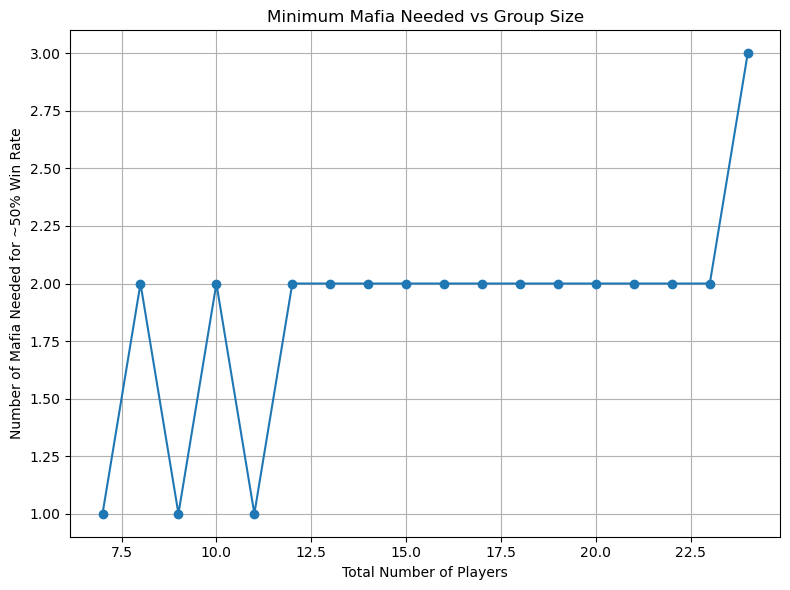

In [36]:
# Untuple
n_vals, mafia_vals = zip(*list_of_mafia)

# Plot results
plt.figure(figsize=(8, 6))
plt.plot(n_vals, mafia_vals, marker='o', linestyle='-')
plt.ylabel('Number of Mafia Needed for ~50% Win Rate')
plt.xlabel('Total Number of Players')
plt.title('Minimum Mafia Needed vs Group Size')
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
print(list_of_mafia[:10])

[(7, 1), (8, 2), (9, 1), (10, 2), (11, 1), (12, 2), (13, 2), (14, 2), (15, 2), (16, 2)]


# Base Model

In [38]:
def mafia_game_simulation(n, m, max_steps=100):
    # n = total players
    # m = number of mafia
    # max_steps = maximum number of night/day cycles to avoid infinite loop

    # Initialize players: assign each player an ID and a role (mafia or townsperson)
    players = {i: 'Mafia' if i < m else 'Town' for i in range(n)}
    alive = set(players.keys())

    t = 0  # time step
    while True:
        # Check win conditions
        mafia_alive = [p for p in alive if players[p] == 'Mafia']
        town_alive = [p for p in alive if players[p] == 'Town']

        if len(mafia_alive) == 0:
            return False  # Town wins
        if len(mafia_alive) >= len(town_alive):
            return True  # Mafia wins

        if t % 2 == 0:
            # Night: Mafia kills a random Town player
            if town_alive:
                victim = random.choice(town_alive)
                alive.remove(victim)
        else:
            # Day: Random player is lynched (could be Mafia or Town)
            victim = random.choice(list(alive))
            alive.remove(victim)

        t += 1
        if t > max_steps:
            break  # just in case

    return None  # if max steps reached

def estimate_mafia_win_prob(n, m, n_simulations=50000):
    wins = sum(mafia_game_simulation(n, m) for _ in range(n_simulations))
    return wins / n_simulations

# Model 1


In [39]:
num_red_edges = 5

In [40]:
def mafia_game_simulation_fixed_red_updated(n, m, num_red_edges, max_steps=100, red_bias_weight=2.0):
    players = {i: 'Mafia' if i < m else 'Town' for i in range(n)}
    alive = set(players.keys())

    # Build red edge graph
    G = nx.Graph()
    G.add_nodes_from(range(n))

    possible_pairs = [(i, j) for i in range(n) for j in range(i+1, n)]
    red_edges = random.sample(possible_pairs, num_red_edges)
    G.add_edges_from(red_edges)

    t = 0
    while True:
        mafia_alive = [p for p in alive if players[p] == 'Mafia']
        town_alive = [p for p in alive if players[p] == 'Town']

        if len(mafia_alive) == 0:
            return False  # Town wins
        if len(mafia_alive) >= len(town_alive):
            return True  # Mafia wins

        if t % 2 == 0:
            # Night: Mafia kills biased Town
            if town_alive:
                town_list = list(town_alive)
                # Calculate night kill weights
                night_weights = []
                for town in town_list:
                    has_enemy = any((G.has_edge(town, mafia) and mafia in alive) for mafia in mafia_alive)
                    weight = red_bias_weight if has_enemy else 1.0
                    night_weights.append(weight)

                # Normalize weights and pick
                total_weight = sum(night_weights)
                night_probs = [w / total_weight for w in night_weights]

                victim = random.choices(town_list, weights=night_probs, k=1)[0]
                alive.remove(victim)
        else:
            # Day: Biased lynch based on red edges
            alive_list = list(alive)

            # Calculate lynch weights
            lynch_weights = []
            for node in alive_list:
                neighbors = list(G.neighbors(node))
                has_enemy = any(neighbor in alive for neighbor in neighbors)
                weight = red_bias_weight if has_enemy else 1.0
                lynch_weights.append(weight)

            total_weight = sum(lynch_weights)
            lynch_probs = [w / total_weight for w in lynch_weights]

            victim = random.choices(alive_list, weights=lynch_probs, k=1)[0]
            alive.remove(victim)

        t += 1
        if t > max_steps:
            break

    return None

def estimate_mafia_win_prob_fixed_red_updated(n, m, num_red_edges, n_simulations=50000):
    wins = sum(mafia_game_simulation_fixed_red_updated(n, m, num_red_edges) for _ in range(n_simulations))
    return wins / n_simulations

# Model 2

In [41]:
num_green_edges = 5

In [42]:
def mafia_game_simulation_fixed_green(n, m, num_green_edges, max_steps=100, green_bias_weight=0.5):
    players = {i: 'Mafia' if i < m else 'Town' for i in range(n)}
    alive = set(players.keys())

    # Build green edge graph
    G = nx.Graph()
    G.add_nodes_from(range(n))

    possible_pairs = [(i, j) for i in range(n) for j in range(i+1, n)]
    green_edges = random.sample(possible_pairs, num_green_edges)
    G.add_edges_from(green_edges)

    t = 0
    while True:
        mafia_alive = [p for p in alive if players[p] == 'Mafia']
        town_alive = [p for p in alive if players[p] == 'Town']

        if len(mafia_alive) == 0:
            return False  # Town wins
        if len(mafia_alive) >= len(town_alive):
            return True  # Mafia wins

        if t % 2 == 0:
            # Night: Mafia kills Town (less likely to kill friends)
            if town_alive:
                town_list = list(town_alive)
                night_weights = []
                for town in town_list:
                    has_friend = any((G.has_edge(town, mafia) and mafia in alive) for mafia in mafia_alive)
                    weight = green_bias_weight if has_friend else 1.0
                    night_weights.append(weight)

                total_weight = sum(night_weights)
                night_probs = [w / total_weight for w in night_weights]

                victim = random.choices(town_list, weights=night_probs, k=1)[0]
                alive.remove(victim)
        else:
            # Day: Biased lynch - less likely to lynch friends
            alive_list = list(alive)

            lynch_weights = []
            for node in alive_list:
                has_friend = any((G.has_edge(node, neighbor) and neighbor in alive) for neighbor in G.neighbors(node))
                weight = green_bias_weight if has_friend else 1.0
                lynch_weights.append(weight)

            total_weight = sum(lynch_weights)
            lynch_probs = [w / total_weight for w in lynch_weights]

            victim = random.choices(alive_list, weights=lynch_probs, k=1)[0]
            alive.remove(victim)

        t += 1
        if t > max_steps:
            break

    return None

def estimate_mafia_win_prob_fixed_green(n, m, num_green_edges, n_simulations=50000):
    wins = sum(mafia_game_simulation_fixed_green(n, m, num_green_edges) for _ in range(n_simulations))
    return wins / n_simulations

# Ultimate model

In [2]:
def mafia_game_simulation_red_green(n, m, num_red_edges, num_green_edges, max_steps=100, red_bias_weight=2.0,green_bias_weight=0.5):
    players = {i: 'Mafia' if i < m else 'Town' for i in range(n)}
    alive = set(players.keys())

    # Build red and green edge graphs
    red_G = nx.Graph()
    green_G = nx.Graph()
    red_G.add_nodes_from(range(n))
    green_G.add_nodes_from(range(n))

    # Create possible unique pairs
    possible_pairs = [(i, j) for i in range(n) for j in range(i+1, n)]
    sampled_pairs = random.sample(possible_pairs, num_red_edges + num_green_edges)

    red_edges = sampled_pairs[:num_red_edges]
    green_edges = sampled_pairs[num_red_edges:]

    red_G.add_edges_from(red_edges)
    green_G.add_edges_from(green_edges)
    
    #print("Red edges:" ,red_edges)
    #print("Green edges:" ,green_edges)

    t = 0
    while True:
        mafia_alive = [p for p in alive if players[p] == 'Mafia']
        town_alive = [p for p in alive if players[p] == 'Town']

        if len(mafia_alive) == 0:
            return False  # Town wins
        if len(mafia_alive) >= len(town_alive):
            return True  # Mafia wins

        if t % 2 == 0:
            # Night: Mafia kills Town
            if town_alive:
                town_list = list(town_alive)
                night_weights = []
                for town in town_list:
                    # Check red and green connections with alive Mafia
                    num_enemy = sum((red_G.has_edge(town, mafia) and mafia in alive) for mafia in mafia_alive)
                    num_friend = sum((green_G.has_edge(town, mafia) and mafia in alive) for mafia in mafia_alive)

                    weight = 1.0
                    #weight of getting killed is proportional to the number of enemies and vice versa for friends
                    if num_enemy > 0:
                        weight = (weight) * red_bias_weight**num_enemy
                    if num_friend > 0:
                        weight = (weight) * (green_bias_weight**num_friend)
                    night_weights.append(weight)
                total_weight = sum(night_weights)
                night_probs = [w / total_weight for w in night_weights]
                victim = random.choices(town_list, weights=night_probs, k=1)[0]
                alive.remove(victim)
        else:
            # Day: Lynch based on red and green biases
            alive_list = list(alive)
            lynch_weights = []
            node_friend = []
            node_enemy = []
            for node in alive_list:
                num_enemy = sum((red_G.has_edge(node, neighbor) and neighbor in alive) for neighbor in red_G.neighbors(node))
                num_friend = sum((green_G.has_edge(node, neighbor) and neighbor in alive) for neighbor in green_G.neighbors(node))
                weight = 1.0
                    #weight of getting lynched is proportional to the number of enemies and vice versa for friends
                if num_enemy > 0:
                    weight = (weight) * red_bias_weight**num_enemy
                if num_friend > 0:
                    weight = (weight) * (green_bias_weight**num_friend)
                lynch_weights.append(weight)
                node_friend.append(num_friend)
                node_enemy.append(num_enemy)
            total_weight = sum(lynch_weights)
            #print("Lynch weight: ",lynch_weights)
            lynch_probs = [w / total_weight for w in lynch_weights]
            victim = random.choices(alive_list, weights=lynch_probs, k=1)[0]
            alive.remove(victim)
            #print("Node Friend", node_friend)
            #print("Node Enemy", node_enemy)
        t += 1
        if t > max_steps:
            break
    return None

def estimate_mafia_win_prob_red_green(n, m, num_red_edges, num_green_edges, n_simulations=50000):
    wins = sum(mafia_game_simulation_red_green(n, m, num_red_edges, num_green_edges) for _ in range(n_simulations))
    return wins / n_simulations



In [44]:
#estimate_mafia_win_prob_red_green(22,2,3,15,1)

In [45]:

def mafia_game_simulation_red_green_plot(n, m, num_red_edges, num_green_edges, max_steps=100, red_bias_weight=2.0, green_bias_weight=0.5):
    players = {i: 'Mafia' if i < m else 'Town' for i in range(n)}
    alive = set(players.keys())

    # Build red and green edge graphs
    red_G = nx.Graph()
    green_G = nx.Graph()
    red_G.add_nodes_from(range(n))
    green_G.add_nodes_from(range(n))

    possible_pairs = [(i, j) for i in range(n) for j in range(i+1, n)]
    sampled_pairs = random.sample(possible_pairs, num_red_edges + num_green_edges)

    red_edges = sampled_pairs[:num_red_edges]
    green_edges = sampled_pairs[num_red_edges:]

    red_G.add_edges_from(red_edges)
    green_G.add_edges_from(green_edges)

    # Combined graph for visualization
    full_G = nx.Graph()
    full_G.add_nodes_from(range(n))
    full_G.add_edges_from(red_edges)
    full_G.add_edges_from(green_edges)

    # Fixed layout for consistent position
    pos = nx.spring_layout(full_G, seed=42)

    t = 0
    while True:
        mafia_alive = [p for p in alive if players[p] == 'Mafia']
        town_alive = [p for p in alive if players[p] == 'Town']

        if len(mafia_alive) == 0:
            print(f'\nGame ended at t={t}: Town wins!\n')
            break
        if len(mafia_alive) >= len(town_alive):
            print(f'\nGame ended at t={t}: Mafia wins!\n')
            break

        plot_current_state(full_G, alive, players, red_edges, green_edges, pos, t)

        if t % 2 == 0:
            # Mafia's move (even t)
            if town_alive:
                town_list = list(town_alive)
                night_weights = []
                for town in town_list:
                    has_enemy = any((red_G.has_edge(town, mafia) and mafia in alive) for mafia in mafia_alive)
                    has_friend = any((green_G.has_edge(town, mafia) and mafia in alive) for mafia in mafia_alive)
                    weight = 1.0
                    if has_enemy:
                        weight *= red_bias_weight
                    if has_friend:
                        weight *= green_bias_weight
                    night_weights.append(weight)

                total_weight = sum(night_weights)
                night_probs = [w / total_weight for w in night_weights]

                victim = random.choices(town_list, weights=night_probs, k=1)[0]
                alive.remove(victim)
                print(f'Night {t//2 + 1}: Mafia killed player {victim}')
        else:
            # Town's move (odd t)
            alive_list = list(alive)
            lynch_weights = []
            for node in alive_list:
                has_enemy = any((red_G.has_edge(node, neighbor) and neighbor in alive) for neighbor in red_G.neighbors(node))
                has_friend = any((green_G.has_edge(node, neighbor) and neighbor in alive) for neighbor in green_G.neighbors(node))
                weight = 1.0
                if has_enemy:
                    weight *= red_bias_weight
                if has_friend:
                    weight *= green_bias_weight
                lynch_weights.append(weight)

            total_weight = sum(lynch_weights)
            lynch_probs = [w / total_weight for w in lynch_weights]

            victim = random.choices(alive_list, weights=lynch_probs, k=1)[0]
            alive.remove(victim)
            print(f'Day {t//2 + 1}: Town lynched player {victim}')

        t += 1

        if t > max_steps:
            print(f'\nGame ended at t={t}: Max steps reached\n')
            break

    return None

def plot_current_state(G, alive, players, red_edges, green_edges, pos, t):
    plt.figure(figsize=(8, 6))

    node_colors = []
    for node in G.nodes():
        if node in alive:
            if players[node] == 'Mafia':
                node_colors.append('red')
            else:
                node_colors.append('blue')
        else:
            node_colors.append('gray')  # Dead players are gray

    # Draw green and red edges between alive players only
    green_edges_alive = [(u, v) for u, v in green_edges if u in alive and v in alive]
    red_edges_alive = [(u, v) for u, v in red_edges if u in alive and v in alive]

    nx.draw_networkx_edges(G, pos, edgelist=green_edges_alive, edge_color='green', style='solid')
    nx.draw_networkx_edges(G, pos, edgelist=red_edges_alive, edge_color='red', style='dashed')

    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=500)

    labels = {node: str(node) for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=labels, font_color='white')

    # ==== NEW part: Better title ====
    if t == 0:
        phase = "Night 1"
    elif t % 2 == 0:
        phase = f"Night {t//2 + 1}"  # Even t (after t=0) = night
    else:
        phase = f"Day {(t+1)//2}"  # Odd t = day

    plt.title(f'Time Step {t} — {phase}', fontsize=16)
    plt.axis('off')
    plt.show()


In [46]:
#mafia_game_simulation_red_green_plot(22,2,1,1)

# Compare

In [47]:
#Initial Condition
n = 22  # total players
m = 2 # number of mafia
n_simulations = 50000

num_red_edges = 30
num_green_edges = 30

In [48]:
# win_rate = estimate_mafia_win_prob(n, m, n_simulations)
# print(f'Estimated Mafia win rate with {m} mafia in {n} players and no relationships: {win_rate:.3f}')

In [49]:
# win_rate_fixed_red_updated = estimate_mafia_win_prob_fixed_red_updated(n, m, num_red_edges, n_simulations)
# print(f'Estimated Mafia win rate with {num_red_edges} red edges (n={n}, m={m}): {win_rate_fixed_red_updated:.3f}')

In [50]:
# win_rate_fixed_green = estimate_mafia_win_prob_fixed_green(n, m, num_green_edges, n_simulations)
# print(f'Estimated Mafia win rate with {num_green_edges} green edges (n={n}, m={m}): {win_rate_fixed_green:.3f}')

In [51]:
# win_rate_red_green = estimate_mafia_win_prob_red_green(n, m, num_red_edges, num_green_edges, n_simulations)
# print(f'Estimated Mafia win rate with {num_red_edges} red edges and {num_green_edges} green edges (n={n}, m={m}): {win_rate_red_green:.3f}')

# Non-Dimensionalization

Assuming complete graph, change proportion of Red and Green edge. Fix n = 22, m = 2

In [3]:
def estimate_mafia_win_prob_red_green_red_green_proportion_experiment(
    n, m, num_red_edges, num_green_edges, n_simulations=50_000,
    red_bias_weight=2.0, green_bias_weight=0.5
):
    # collect 0/1 outcomes
    outcomes = np.array([
        mafia_game_simulation_red_green(
            n, m,
            num_red_edges, num_green_edges,
            red_bias_weight=red_bias_weight,
            green_bias_weight=green_bias_weight
        )
        for _ in range(n_simulations)
    ])
    p = outcomes.mean()
    se = np.sqrt(p * (1 - p) / n_simulations)
    return p, se

def red_green_proportion_experiment(
    n, m,
    step=0.01,
    red_bias_weight=2.0, green_bias_weight=0.5,
    n_simulations=20000
):
    total_edges = n * (n - 1) // 2
    proportions = np.arange(step, 1.0 + step, step)

    win_rates = []
    error_bars = []

    for red_prop in proportions:
        num_red_edges = int(red_prop * total_edges)
        num_green_edges = total_edges - num_red_edges

        p, se = estimate_mafia_win_prob_red_green_red_green_proportion_experiment(
            n=n,
            m=m,
            num_red_edges=num_red_edges,
            num_green_edges=num_green_edges,
            n_simulations=n_simulations,
            red_bias_weight=red_bias_weight,
            green_bias_weight=green_bias_weight
        )
        win_rates.append(p)
        error_bars.append(se)
    win_prop_dict  = {
        "red proportion" : proportions.tolist(),
        "win rate":  win_rates,
        "error": error_bars
    }
    return win_prop_dict



'''
    plt.figure(figsize=(8, 5))
    plt.errorbar(
        proportions,
        win_rates,
        yerr=error_bars,
        fmt='o-',
        capsize=4,
        label='Win rate ±1 SE'
    )

    plt.xlabel("Proportion of Red Edges")
    plt.ylabel("Mafia Win Rate")
    plt.title("Mafia Win Rate vs. Proportion of Red Edges (with SE error bars)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
'''
# Run the experiment
win_prop = red_green_proportion_experiment(
    n=22,
    m=2,
    step=0.01,
    red_bias_weight=2.0,
    green_bias_weight=0.5,
    n_simulations=50000
)

In [ ]:
win_prop_df = pd.DataFrame(win_prop)
#win_prop_df.to_csv('win_prop_erdos_renyi_data.csv', index=False)

Fix proportion of red and green at 0.5, fix n = 22, fix red weight at 2.0, green weight at 0.5, change number of edges

In [4]:
def estimate_mafia_win_prob_red_green_num_edge_experiment(
    n, m, num_edge, n_simulations=50000,
    red_bias_weight=2.0, green_bias_weight=0.5
):
    # split the edges (floor so you never exceed num_edge)
    red_edges = math.floor(num_edge / 2)
    green_edges = math.floor(num_edge / 2)

    # run simulations and collect 0/1 outcomes
    outcomes = np.array([
        mafia_game_simulation_red_green(
            n, m, red_edges, green_edges,
            red_bias_weight=red_bias_weight,
            green_bias_weight=green_bias_weight
        )
        for _ in range(n_simulations)
    ])
    p = outcomes.mean()
    # standard error of a Bernoulli(p) estimate: sqrt(p*(1-p)/N)
    se = np.sqrt(p * (1 - p) / n_simulations)
    return p, se

def num_edge_experiment(
    n=22,
    m=2,
    step=1,
    n_simulations=50000,
    red_bias_weight=2.0,
    green_bias_weight=0.5,
):
    # maximum possible edges in a complete graph of n nodes
    max_edge = n * (n - 1) // 2
    num_edge_list = np.arange(1, max_edge + 1, step)

    win_rates = []
    error_bars = []

    for edge in num_edge_list:
        p, se = estimate_mafia_win_prob_red_green_num_edge_experiment(
            n=n,
            m=m,
            num_edge=edge,
            n_simulations=n_simulations,
            red_bias_weight=red_bias_weight,
            green_bias_weight=green_bias_weight
        )
        win_rates.append(p)
        error_bars.append(se)

    results = {
        "num_edge": num_edge_list.tolist(),
        "win_rate": win_rates,
        "error": error_bars
    }
    return results

win_edge = num_edge_experiment(n_simulations=50000)

In [ ]:
win_edge_df = pd.DataFrame(win_edge)
#win_edge_df.to_csv('win_edge_erdos_renyi_data.csv', index=False)

Fix proportion of red and green at 1 green,1 red, fix n = 22, change weight

In [7]:
import numpy as np
import math

def estimate_mafia_win_prob_red_green_edge_weight_experiment(
    n, m, red_bias, green_bias, n_simulations=50_000,
    red_edges=1, green_edges=1
):
    """
    Runs `n_simulations` of the Mafia game with fixed #edges but varying
    red/green bias weights. Returns (win_rate, standard_error).
    """
    outcomes = np.array([
        mafia_game_simulation_red_green(
            n, m, red_edges, green_edges,
            red_bias_weight=red_bias,
            green_bias_weight=green_bias
        )
        for _ in range(n_simulations)
    ])
    p  = outcomes.mean()
    se = np.sqrt(p * (1 - p) / n_simulations)
    return p, se

def edge_weight_experiment(
    n=22,
    m=2,
    red_bias_start=1,
    red_bias_end=100,
    red_bias_step=1,
    green_bias_start=0.01,
    green_bias_end=1.01,
    green_bias_step=0.01,
    n_simulations=50_000
):
    # Sweep RED bias
    red_bias_list = np.arange(red_bias_start, red_bias_end, red_bias_step)
    win_red, err_red = [], []
    for rb in red_bias_list:
        p, se = estimate_mafia_win_prob_red_green_edge_weight_experiment(
            n, m, red_bias=rb, green_bias=0.5,
            n_simulations=n_simulations
        )
        win_red.append(p)
        err_red.append(se)

    # Sweep GREEN bias
    green_bias_list = np.arange(
        green_bias_start, green_bias_end, green_bias_step
    )
    win_green, err_green = [], []
    for gb in green_bias_list:
        p, se = estimate_mafia_win_prob_red_green_edge_weight_experiment(
            n, m, red_bias=2.0, green_bias=gb,
            n_simulations=n_simulations
        )
        win_green.append(p)
        err_green.append(se)

    return {
        "red_bias":       red_bias_list.tolist(),
        "win_rate_red":   win_red,
        "error_red":      err_red,
        "green_bias":     green_bias_list.tolist(),
        "win_rate_green": win_green,
        "error_green":    err_green,
    }

win_weight = edge_weight_experiment()


In [ ]:
win_weight_red = {
    "red_bias": win_weight["red_bias"],
    "win_rate_red": win_weight["win_rate_red"],
    "error_red": win_weight["error_red"]
}

win_weight_green = {
    "green_bias": win_weight["green_bias"],
    "win_rate_green": win_weight["win_rate_green"],
    "error_green": win_weight["error_green"]
}

win_weight_red_df = pd.DataFrame(win_weight_red)
#win_weight_red_df.to_csv('win_weight_red_erdos_renyi_data.csv', index=False)

win_weight_green_df = pd.DataFrame(win_weight_green)
#win_weight_green_df.to_csv('win_weight_green_erdos_renyi_data.csv', index=False)

### Try Heatmap

In [32]:
n = 22
m = 2
n_simulations = 50000
max_edges = n * (n-1) // 2 
edge_steps = np.linspace(0, max_edges, 46, dtype=int)
ratio_steps = np.linspace(0, 1, 21)  

# Storage
results = []

for num_edges in edge_steps:
    for red_ratio in ratio_steps:
        num_red_edges = int(red_ratio * num_edges)
        num_green_edges = num_edges - num_red_edges

        win_rate = estimate_mafia_win_prob_red_green(
            n=n,
            m=m,
            num_red_edges=num_red_edges,
            num_green_edges=num_green_edges,
            n_simulations=n_simulations
        )

        results.append({
            'num_edges': num_edges,
            'red_ratio': red_ratio,
            'mafia_win_rate': win_rate
        })

# # Convert to DataFrame
df = pd.DataFrame(results)


In [34]:
# Save it
df.to_csv('mafia_win_rate_heatmap_data.csv', index=False)

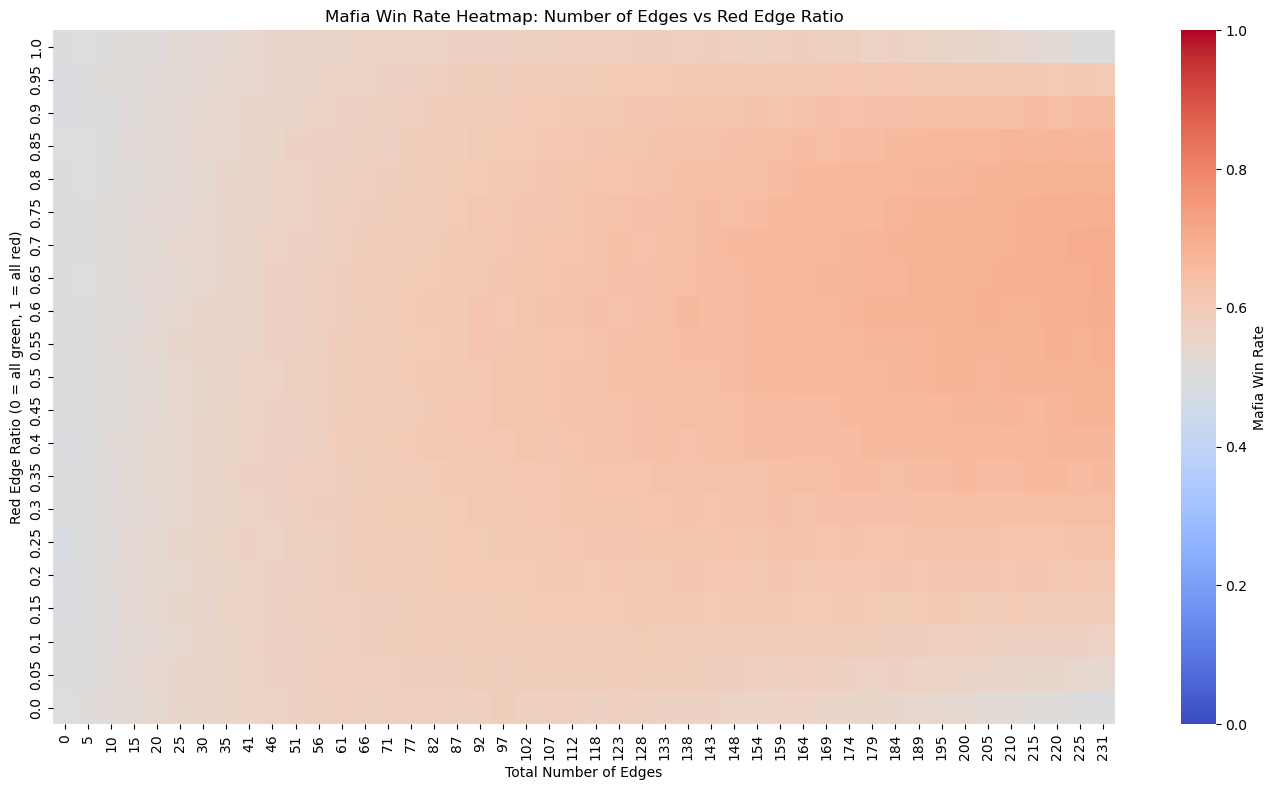

In [35]:
# Pivot for heatmap
df = pd.read_csv('mafia_win_rate_heatmap_data.csv')
df['red_ratio'] = df['red_ratio'].round(2)
df_sorted = df.sort_values(by='red_ratio', ascending=True)
heatmap_data = df_sorted.pivot(index='red_ratio', columns='num_edges', values='mafia_win_rate')

# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(
    heatmap_data,
    cmap='coolwarm',
    vmin=0,
    vmax=1,
    cbar_kws={'label': 'Mafia Win Rate'}
)
plt.title('Mafia Win Rate Heatmap: Number of Edges vs Red Edge Ratio')
plt.xlabel('Total Number of Edges')
plt.ylabel('Red Edge Ratio (0 = all green, 1 = all red)')
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.show()


Fitting Models with Equations

Coefficients and precision:
 Intercept    0.081312
x            1.524283
x2           1.201538
x3          -2.586889
precision    7.319629
dtype: float64

Standard errors:
 Intercept    0.021657
x            0.187730
x2           0.433579
x3           0.283087
precision    0.141378
dtype: float64

Full summary:
                              BetaModel Results                               
Dep. Variable:                      y   Log-Likelihood:                 298.46
Model:                      BetaModel   AIC:                            -586.9
Method:            Maximum Likelihood   BIC:                            -573.9
Date:                Thu, 01 May 2025                                         
Time:                        09:16:40                                         
No. Observations:                 100                                         
Df Residuals:                      95                                         
Df Model:                           3                  

/Users/khoa/miniforge3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The logit link alias is deprecated. Use Logit instead. The logit link alias will be removed after the 0.15.0 release.
  warnings.warn(


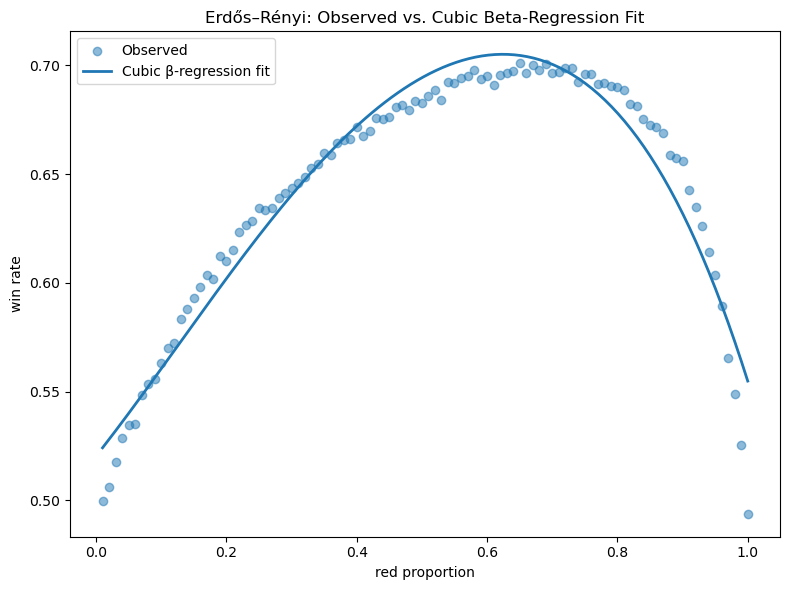

In [31]:
df = pd.read_csv('win_prop_erdos_renyi_data.csv')
# rename for convenience
df = df.rename(columns={'red proportion':'x', 'win rate':'y'})
df['x2'] = df.x**2
df['x3'] = df.x**3

# 2) Define and fit the cubic‐polynomial BetaModel
model = BetaModel.from_formula(
    'y ~ x + x2 + x3',
    data=df,
    link=logit()
)
result = model.fit()

# 3) Inspect estimates
print("Coefficients and precision:\n", result.params)
print("\nStandard errors:\n", result.bse)
print("\nFull summary:")
print(result.summary())

# 4) Plot observed vs. fitted curve
x_vals = df['x']
y_vals = df['y']

# build a grid for smoothing
x_grid = np.linspace(x_vals.min(), x_vals.max(), 200)
grid_df = pd.DataFrame({
    'x':  x_grid,
    'x2': x_grid**2,
    'x3': x_grid**3
})

# get predicted mean on the grid
mu_grid = result.predict(grid_df)

plt.figure(figsize=(8,6))
plt.scatter(x_vals, y_vals, alpha=0.5, label='Observed')
plt.plot(x_grid, mu_grid, lw=2, label='Cubic β-regression fit')
plt.xlabel('red proportion')
plt.ylabel('win rate')
plt.title('Erdős–Rényi: Observed vs. Cubic Beta-Regression Fit')
plt.legend()
plt.tight_layout()
plt.show()

## Mathematical Model Building

In [48]:
df = pd.read_csv('mafia_win_rate_heatmap_data.csv')

df = df.copy()
df['red_ratio_sq'] = df['red_ratio'] ** 2
df['num_edges_sq'] = df['num_edges'] ** 2

model = smf.ols(
    'mafia_win_rate ~ red_ratio + num_edges + red_ratio:num_edges + red_ratio_sq + num_edges_sq',
    data=df
).fit()

beta_0 = model.params['Intercept']
beta_1 = model.params['red_ratio']
beta_2 = model.params['num_edges']
beta_3 = model.params['red_ratio:num_edges']
beta_4 = model.params['red_ratio_sq']
beta_5 = model.params['num_edges_sq']
r_squared = model.rsquared

print("📊 Model Summary:")
print(model.summary())
print(" Coefficients:")
print(f"  beta_0 = {beta_0:.4f}")
print(f"  beta_1 = {beta_1:.4f}")
print(f"  beta_2 = {beta_2:.4f}")
print(f"  beta_3 = {beta_3:.4f}")
print(f"  beta_4 = {beta_4:.4f}")
print(f"  beta_5 = {beta_5:.8f}")
print(f"\nR-squared: {r_squared:.4f}")

📊 Model Summary:
                            OLS Regression Results                            
Dep. Variable:         mafia_win_rate   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     1262.
Date:                Fri, 02 May 2025   Prob (F-statistic):               0.00
Time:                        09:12:46   Log-Likelihood:                 2487.8
No. Observations:                 966   AIC:                            -4964.
Df Residuals:                     960   BIC:                            -4934.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept        

In [49]:
def predict(red_ratio, num_edges):
    return (
        beta_0
        + beta_1 * red_ratio
        + beta_2 * num_edges
        + beta_3 * red_ratio * num_edges
        + beta_4 * red_ratio ** 2
        + beta_5 * num_edges ** 2
    )

def plot_vs_red_ratio(fixed_edges):
    red_vals = np.linspace(0, 1, 100)
    predicted = predict(red_vals, fixed_edges)
    actual = df[np.abs(df['num_edges'] - fixed_edges) <= 2]

    plt.figure(figsize=(8, 5))
    plt.plot(red_vals, predicted, label='Predicted (Model)', color='blue')
    plt.scatter(actual['red_ratio'], actual['mafia_win_rate'], color='orange', alpha=0.6, label='Simulated Data')
    plt.title(f'Mafia Win Rate vs Red Ratio (Edges = {fixed_edges})')
    plt.xlabel('Red Edge Ratio')
    plt.ylabel('Mafia Win Rate')
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_vs_num_edges(fixed_red_ratio):
    edge_vals = np.linspace(df['num_edges'].min(), df['num_edges'].max(), 100)
    predicted = predict(fixed_red_ratio, edge_vals)
    actual = df[np.abs(df['red_ratio'] - fixed_red_ratio) <= 0.01]

    plt.figure(figsize=(8, 5))
    plt.plot(edge_vals, predicted, label='Predicted (Model)', color='green')
    plt.scatter(actual['num_edges'], actual['mafia_win_rate'], color='orange', alpha=0.6, label='Simulated Data')
    plt.title(f'Mafia Win Rate vs Number of Edges (Red Ratio = {fixed_red_ratio})')
    plt.xlabel('Number of Edges')
    plt.ylabel('Mafia Win Rate')
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

0.5977216329678788


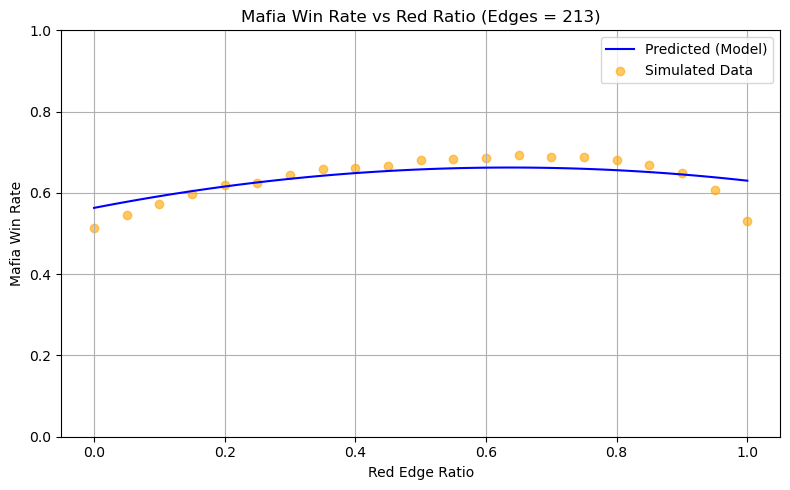

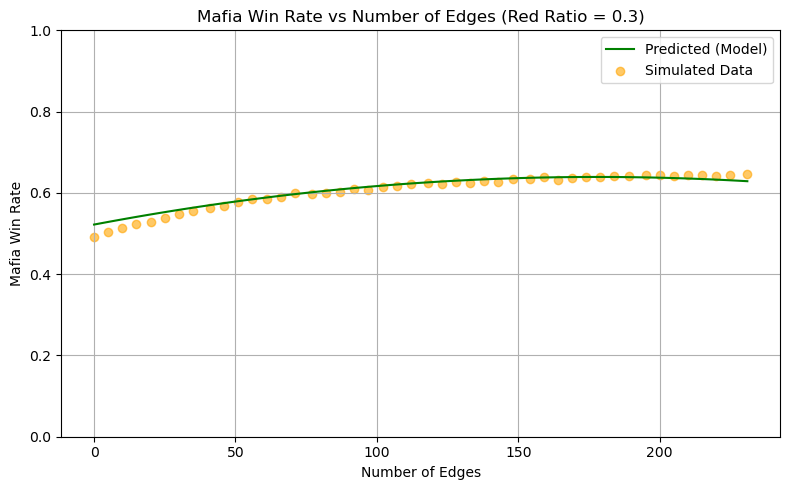

In [50]:
print(predict(0.3, 72))
plot_vs_red_ratio(213)
plot_vs_num_edges(0.3)

# Testing Robustness for Prefrential Attachment Graph

In [5]:
def PA_mafia_game_simulation_red_green(n, m,m_ba, prop_red_edges,
                              red_bias_weight=2.0, green_bias_weight=0.5,
                              max_steps=100):
    # Number of Mafia by sqrt rule
    num_mafia = m
    players = {i: 'Mafia' if i < num_mafia else 'Town' for i in range(n)}
    alive = set(players.keys())

    # Build single BA network
    G = nx.barabasi_albert_graph(n, min(m_ba, n-1))
    edges = list(G.edges())
    # Color edges red vs green by sampling
    num_red = int(prop_red_edges * len(edges))
    red_edges = set(random.sample(edges, num_red))
    green_edges = set(edges) - red_edges

    red_G = nx.Graph()
    red_G.add_nodes_from(range(n))
    red_G.add_edges_from(red_edges)
    green_G = nx.Graph()
    green_G.add_nodes_from(range(n))
    green_G.add_edges_from(green_edges)

    t = 0
    while True:
        mafia_alive = [p for p in alive if players[p] == 'Mafia']
        town_alive = [p for p in alive if players[p] == 'Town']

        # Win/loss conditions
        if not mafia_alive:
            return False
        if len(mafia_alive) >= len(town_alive):
            return True

        if t % 2 == 0:
            # Night: Mafia kill one Townsperson
            weights = []
            for town in town_alive:
                num_enemy = sum(1 for ma in mafia_alive if red_G.has_edge(town, ma))
                num_friend = sum(1 for ma in mafia_alive if green_G.has_edge(town, ma))
                w = (red_bias_weight ** num_enemy) * (green_bias_weight ** num_friend)
                weights.append(w)
            victim = random.choices(town_alive, weights=weights, k=1)[0]
            alive.remove(victim)
        else:
            # Day: all alive vote to lynch one
            alive_list = list(alive)
            weights = []
            for node in alive_list:
                num_enemy = sum(1 for nei in red_G.neighbors(node) if nei in alive)
                num_friend = sum(1 for nei in green_G.neighbors(node) if nei in alive)
                w = (red_bias_weight ** num_enemy) * (green_bias_weight ** num_friend)
                weights.append(w)
            victim = random.choices(alive_list, weights=weights, k=1)[0]
            alive.remove(victim)

        t += 1
        if t > max_steps:
            return None

Fix n = 22, m = 2. We change the Barabasi-Albert "m" and the proportion of red to green edges.

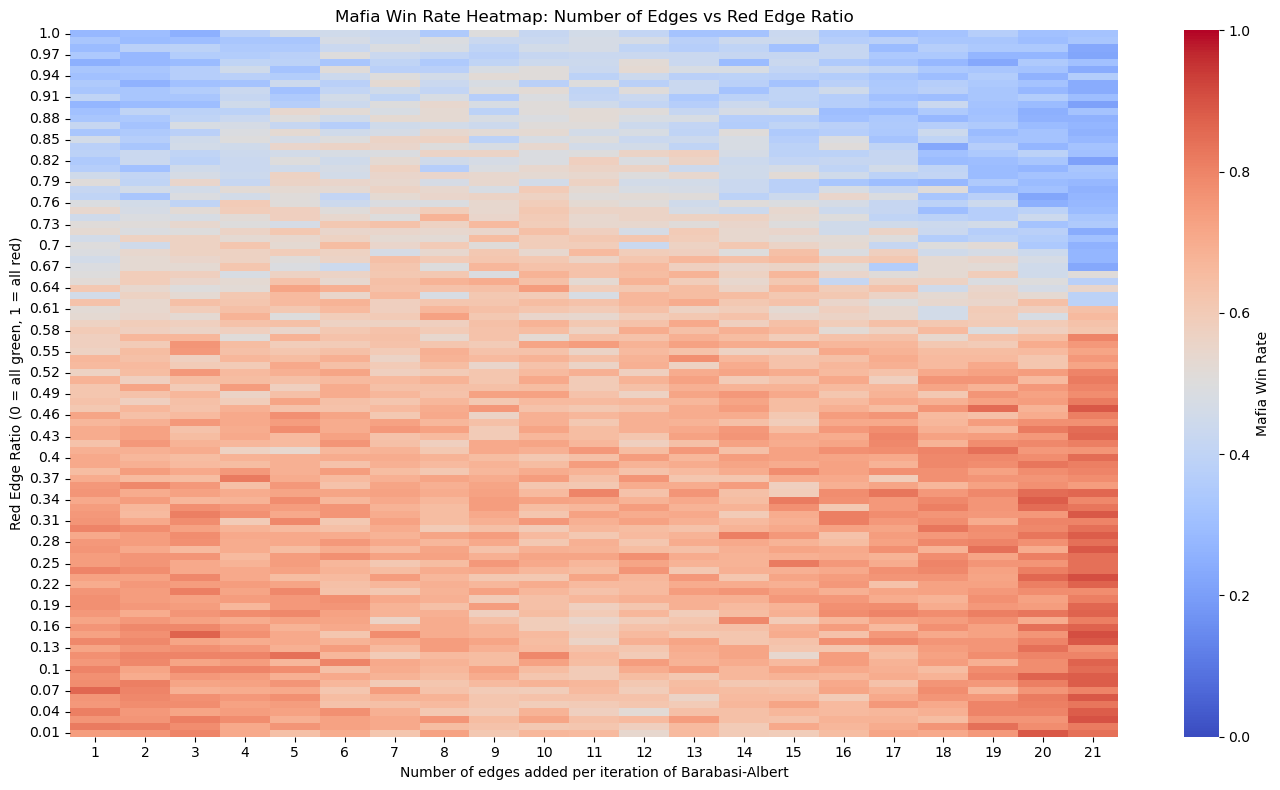

In [ ]:
results = []
def PA_estimate_mafia_win_prob_red_green_red_green_proportion_mba_experiment(m_ba, prop_red_edges,n=22, m=2,
                               n_simulations=5000,
                               red_bias_weight=2.0, green_bias_weight=0.5,
                               max_steps=100):
    wins = 0
    for _ in range(n_simulations):
        result = PA_mafia_game_simulation_red_green(
            n, m,m_ba, prop_red_edges,
            red_bias_weight, green_bias_weight, max_steps)
        if result:
            wins += 1
    return wins / n_simulations


def PA_red_green_proportion_experiment(n, m, max_steps=1000, red_bias_weight=2.0, green_bias_weight=0.5, step=0.01):
    proportions = np.arange(step, 1.0 + step, step)
    m_ba = np.arange(1,22,1)
    win_rates = []
    for initial_m in m_ba:
        for red_prop in proportions:
            win_rate = PA_estimate_mafia_win_prob_red_green_red_green_proportion_mba_experiment(initial_m,red_prop)
            win_rates.append(win_rate)
    
            results.append({
                'm_barabasi_albert': initial_m,
                'red_ratio': red_prop,
                'mafia_win_rate': win_rate
            })
    df = pd.DataFrame(results)
    # df.to_csv('PA_mafia_win_rate_heatmap_data.csv', index=False)
    
PA_red_green_proportion_experiment(22, 2, max_steps=100, red_bias_weight=2.0, green_bias_weight=0.5, step=0.01)

df_sorted = df.sort_values(by='red_ratio', ascending=True)
heatmap_data = df_sorted.pivot(index='red_ratio', columns='m_barabasi_albert', values='mafia_win_rate')

# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(
    heatmap_data,
    cmap='coolwarm',
    vmin=0,
    vmax=1,
    cbar_kws={'label': 'Mafia Win Rate'}
)
plt.title('Mafia Win Rate Heatmap: Number of Edges vs Red Edge Ratio')
plt.xlabel('Number of edges added per iteration of Barabasi-Albert')
plt.ylabel('Red Edge Ratio (0 = all green, 1 = all red)')
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.show()

#### For loop to run through different parameters

Questions:

Weight estimation: How to find the weight of red/green edges
sensitivity analysis

DE: Difference Equation to find probability?



Next steps
Final product: probability function on n, r, and g from the simulations => NETWORK MODEL

think about nondimensionalization where growth size
think of the fraction of edges would be ratio (KHOA)
finding boundaries.

even though we modeled the simulations based on our hypothesis.


next steps:
nondimensionalization on r and g and boundaries analysis
t-test on p-value => significant difference when adding red/green edges?
probability function on n, r, and g from the simulations